In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

# EXERCISE 1

## Part 1

In [2]:
# Parameters of the poisson process
T = 100
N = 42
lam = T / N
print("λ =", lam)

# Number of poisson process simulations
repetitions = int(1e5)

λ = 2.380952380952381


In [3]:
def get_interarrival_times_from_uniform(
    T: float, N: int, repetitions: int = 1
) -> np.ndarray:
    """
    Generate interarrival times from a uniform sample of size N in the interval [0, T].

    Args:
        T (float): The upper limit of the interval.
        N (int): The number of samples to generate.
        repetitions (int): The number of repetitions. Default is 1.
    Returns:
        np.ndarray: A 2D array of shape (repetitions, N) containing the interarrival times.
    """
    # Generate arrivals from uniform distribution
    samples = np.random.uniform(0, T, (repetitions, N))
    samples.sort(axis=1) # sort each row to ease the calculation of interarrival times

    # Calculate interarrival times
    interarrivals = np.concatenate(
        (samples[:, :1], np.diff(samples, axis=1)), axis=1
    )  # shape (repetitions, N)

    return interarrivals

In [4]:
interarrivals = get_interarrival_times_from_uniform(T, N, repetitions)
all_interarrivals = interarrivals.flatten()

In [9]:
samples_means = np.mean(interarrivals, axis=1)
samples_vars = np.var(interarrivals, axis=1)

estimated_mean = np.mean(samples_means)
estimated_var = np.mean(samples_vars)

aggregated_mean = np.mean(all_interarrivals)
aggregated_var = np.var(all_interarrivals)

# Calculate the 95% confidence interval using bootstrap percentile method
b_means = np.zeros(999)
b_vars = np.zeros(999)
b_aggr_means = np.zeros(999)
b_aggr_vars = np.zeros(999)
for i in range(999):
    b_mean_samples = np.random.choice(samples_means, size=repetitions, replace=True)
    b_means[i] = np.mean(b_mean_samples)

    b_var_samples = np.random.choice(samples_vars, size=repetitions, replace=True)
    b_vars[i] = np.mean(b_var_samples)

    b_aggr_mean_samples = np.random.choice(all_interarrivals, size=repetitions, replace=True)
    b_aggr_means[i] = np.mean(b_aggr_mean_samples)

    b_aggr_var_samples = np.random.choice(all_interarrivals, size=repetitions, replace=True)
    b_aggr_vars[i] = np.var(b_aggr_var_samples)
# Sort the bootstrap means and variances
b_means.sort()
b_vars.sort()
b_aggr_means.sort()
b_aggr_vars.sort()

# Calculate the 95% confidence interval
mean_ci_lower, mean_ci_upper = b_means[25], b_means[975]
var_ci_lower, var_ci_upper = b_vars[25], b_vars[975]
aggr_mean_ci_lower, aggr_mean_ci_upper = b_aggr_means[25], b_aggr_means[975]
aggr_var_ci_lower, aggr_var_ci_upper = b_aggr_vars[25], b_aggr_vars[975]

print("Mean of means and mean of variances of samples")
print(f"Mean:\t\t {estimated_mean:.2f} CI: [{mean_ci_lower:.2f}, {mean_ci_upper:.2f}]")
print(f"Variance:\t {estimated_var:.2f} CI: [{var_ci_lower:.2f}, {var_ci_upper:.2f}]")
print("------------------------------------------------")
print(f"Aggregated results from the merge of all samples")
print(f"Mean:\t\t {aggregated_mean:.2f} CI: [{aggr_mean_ci_lower:.2f}, {aggr_mean_ci_upper:.2f}]")
print(f"Variance:\t {aggregated_var:.2f} CI: [{aggr_var_ci_lower:.2f}, {aggr_var_ci_upper:.2f}]")

Mean of means and mean of variances of samples
Mean:		 2.33 CI: [2.33, 2.33]
Variance:	 5.16 CI: [5.15, 5.17]
------------------------------------------------
Aggregated results from the merge of all samples
Mean:		 2.33 CI: [2.31, 2.34]
Variance:	 5.16 CI: [5.08, 5.25]


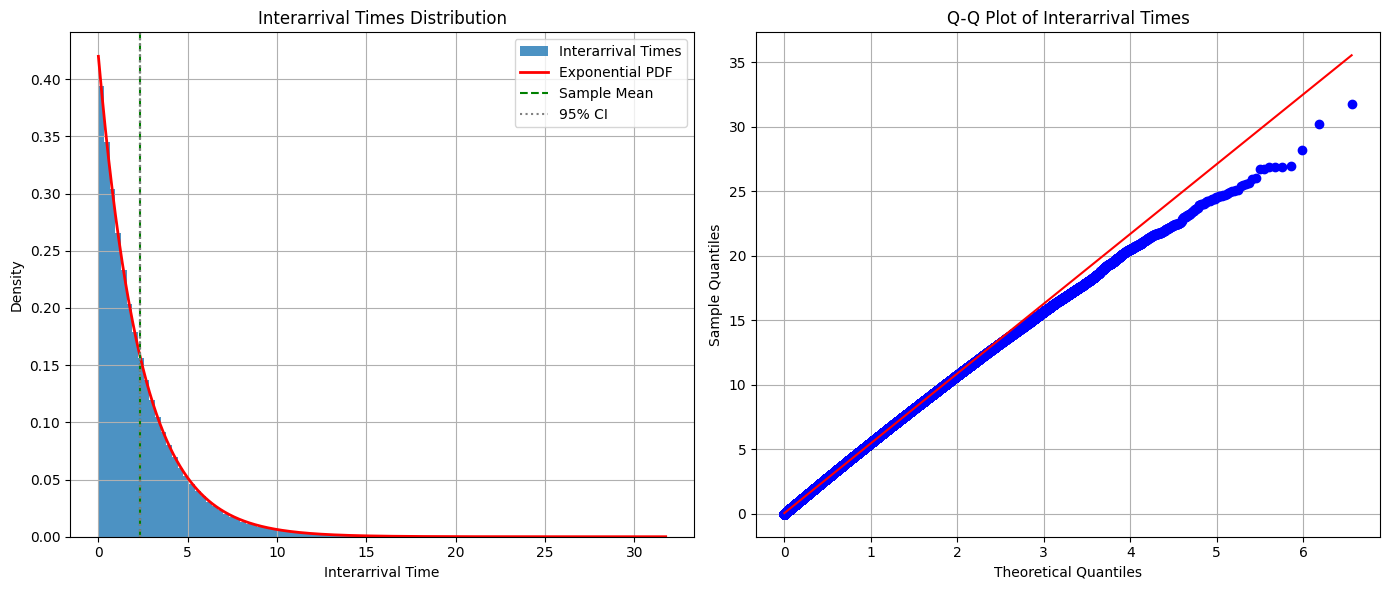

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# -------- Left Plot: Histogram + PDF --------
ax1 = axes[0]
ax1.hist(all_interarrivals, bins=100, density=True, alpha=0.8, label="Interarrival Times")

x = np.linspace(0, np.max(all_interarrivals), 1000)
ax1.plot(x, stats.expon.pdf(x, scale=lam), "r-", lw=2, label="Exponential PDF")

# Plot mean and CI
ax1.axvline(aggregated_mean, color="green", linestyle="--", label="Sample Mean")
ax1.axvline(aggr_mean_ci_lower, color="gray", linestyle=":", label="95% CI")
ax1.axvline(aggr_mean_ci_upper, color="gray", linestyle=":")

ax1.set_title("Interarrival Times Distribution")
ax1.set_xlabel("Interarrival Time")
ax1.set_ylabel("Density")
ax1.legend()
ax1.grid()

# -------- Right Plot: Q-Q Plot --------
ax2 = axes[1]
stats.probplot(all_interarrivals, dist="expon", sparams=(0, 1 / lam), plot=ax2)
ax2.set_title("Q-Q Plot of Interarrival Times")
ax2.set_xlabel("Theoretical Quantiles")
ax2.set_ylabel("Sample Quantiles")
ax2.grid()


plt.tight_layout()
plt.show()

## Part 2

In [11]:
def get_arrival_times_from_exp(
    T: float, N: int, lam: float, repetitions: int = 1
) -> np.ndarray:
    """
    Generate arrival times from sampling N exponential interarrival times with rate λ in the interval [0, T].

    Args:
        T (float): The upper limit of the interval.
        N (int): The number of samples to generate.
        lam (float): The rate parameter of the exponential distribution.
        repetitions (int): The number of repetitions. Default is 1.
    Returns:
        np.ndarray: A 2D array of shape (repetitions, N) containing the arrival times.
    """
    samples = np.empty((repetitions, N))
    i = 0

    while i < repetitions:
        sample = np.random.exponential(scale=lam, size=N)

        # Compute the cumulative sum of the sample to get arrival times
        sample = np.cumsum(sample)

        # Check if the last arrival time is within the interval [0, T]
        if sample[-1] <= T:
            samples[i] = sample
            i += 1

    return samples

In [12]:
arrivals = get_arrival_times_from_exp(T, N, lam, repetitions)
all_arrivals = arrivals.flatten()

In [ ]:
samples_means = np.mean(arrivals, axis=1)
samples_vars = np.var(arrivals, axis=1)

estimated_mean = np.mean(samples_means)
estimated_var = np.mean(samples_vars)

aggregated_mean = np.mean(all_arrivals)
aggregated_var = np.var(all_arrivals)

# Calculate the 95% confidence interval using bootstrap percentile method
b_means = np.zeros(999)
b_vars = np.zeros(999)
b_aggr_means = np.zeros(999)
b_aggr_vars = np.zeros(999)
for i in range(999):
    b_mean_samples = np.random.choice(samples_means, size=repetitions, replace=True)
    b_means[i] = np.mean(b_mean_samples)

    b_var_samples = np.random.choice(samples_vars, size=repetitions, replace=True)
    b_vars[i] = np.mean(b_var_samples)

    b_aggr_mean_samples = np.random.choice(all_arrivals, size=repetitions, replace=True)
    b_aggr_means[i] = np.mean(b_aggr_mean_samples)

    b_aggr_var_samples = np.random.choice(all_arrivals, size=repetitions, replace=True)
    b_aggr_vars[i] = np.var(b_aggr_var_samples)
# Sort the bootstrap means and variances
b_means.sort()
b_vars.sort()
b_aggr_means.sort()
b_aggr_vars.sort()

# Calculate the 95% confidence interval
mean_ci_lower, mean_ci_upper = b_means[25], b_means[975]
var_ci_lower, var_ci_upper = b_vars[25], b_vars[975]
aggr_mean_ci_lower, aggr_mean_ci_upper = b_aggr_means[25], b_aggr_means[975]
aggr_var_ci_lower, aggr_var_ci_upper = b_aggr_vars[25], b_aggr_vars[975]

print("Mean of means and mean of variances of samples")
print(f"Mean:\t\t {estimated_mean:.2f} CI: [{mean_ci_lower:.2f}, {mean_ci_upper:.2f}]")
print(f"Variance:\t {estimated_var:.2f} CI: [{var_ci_lower:.2f}, {var_ci_upper:.2f}]")
print("------------------------------------------------")
print(f"Aggregated results from the merge of all samples")
print(f"Mean:\t\t {aggregated_mean:.2f} CI: [{aggr_mean_ci_lower:.2f}, {aggr_mean_ci_upper:.2f}]")
print(f"Variance:\t {aggregated_var:.2f} CI: [{aggr_var_ci_lower:.2f}, {aggr_var_ci_upper:.2f}]")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# -------- Left Plot: Histogram + PDF --------
ax1 = axes[0]
ax1.hist(all_arrivals, bins=100, density=True, alpha=0.8, label="Arrival Times")

x = np.linspace(0, np.max(all_arrivals), 1000)
ax1.plot(x, stats.uniform.pdf(x, 0, T), "r-", lw=2, label="Uniform PDF")

# Plot mean and CI
ax1.axvline(aggregated_mean, color="green", linestyle="--", label="Estimated Mean")
ax1.axvline(aggr_mean_ci_upper, color="gray", linestyle=":")
ax1.axvline(aggr_mean_ci_lower, color="gray", linestyle=":", label="95% CI")

ax1.set_title("Arrival Times Distribution")
ax1.set_xlabel("Arrival Time")
ax1.set_ylabel("Density")
ax1.legend()
ax1.grid()

# Add mean/var text inside the left plot
textstr = f"Sample Mean: {aggregated_mean:.2f}\nSample Var: {aggregated_var:.2f}"

# -------- Right Plot: Q-Q Plot --------
ax2 = axes[1]
stats.probplot(all_arrivals, dist="uniform", sparams=(0, 1 / lam), plot=ax2)
ax2.set_title("Q-Q Plot of Arrival Times")
ax2.set_xlabel("Theoretical Quantiles")
ax2.set_ylabel("Sample Quantiles")
ax2.grid()

plt.tight_layout()
plt.show()

: 

# EXERCISE 2

In [9]:
A = 8.8480182

In [10]:
def fn_vectorized(x):
    x = np.asarray(x)
    # Only compute for -3 <= x <= 3, else 0
    return np.where((x >= -3) & (x <= 3), (x**2) * (np.sin(np.pi * x)) ** 2, 0)


def f_vectorized(x, A):
    x = np.asarray(x)
    # Only compute for -3 <= x <= 3, else 0
    return np.where(
        (x >= -3) & (x <= 3), (1 / A) * (x**2) * (np.sin(np.pi * x)) ** 2, 0
    )


def g_vectorized(x):
    x = np.asarray(x)
    return np.where((x >= -3) & (x <= 3), (x**2) / 18, 0)


def cg_vectorized(x, A):
    x = np.asarray(x)
    return np.where((x >= -3) & (x <= 3), (x**2) / A, 0)


def g_inv_vectorized(u):
    u = np.asarray(u)
    # Using np.sqrt ensures the square root is computed correctly for negative numbers.
    return np.where((u >= 0) & (u <= 1), 3 * np.cbrt(2 * (u - (1 / 2))), 0)


def cg_inv_vectorized(u, A):
    u = np.asarray(u)
    # Using np.cbrt ensures the cube root is computed correctly for negative numbers.
    return np.where((u >= 0) & (u <= 1), np.cbrt(3 * A * u - 27), 0)

In [11]:
# rejection sampling
NUM_SAMPLES = int(1e7)


def rejection_sampling(num_samples=NUM_SAMPLES):
    # Sample X from proposal g(x) using its inverse CDF
    U1 = np.random.uniform(0, 1, num_samples)
    X = g_inv_vectorized(U1)  # X ~ g(x)

    a = f_vectorized(X, A)
    b = cg_vectorized(X, A)  # scaled cg(x)
    # Sample uniform U2 ~ Uniform[0, cg(X)]
    U2 = np.random.uniform(0, b, num_samples)

    rej_vec = np.where(U2 < a, 1, 0)  # 1 if accepted, 0 if rejected
    acc_count = np.sum(rej_vec)

    return X, rej_vec, acc_count


# rejection sampling without knowledge of the scaling factor of f(x)
def rejection_sampling_2(n):
    X = np.random.uniform(-3, 3, n)
    U = np.random.uniform(0, 9, n)

    f_not_normalized = fn_vectorized(X)
    rej_vec = np.where(U < f_not_normalized, 1, 0)  # 1 if accepted, 0 if rejected
    acc_count = np.sum(rej_vec)

    return X, rej_vec, acc_count

In [12]:
def sample_valid(n_valid, batch_size):
    """
    Returns an array of n_valid accepted samples using run_rejection_sampling.
    batch_size specifies the number of points to generate in each rejection sampling run.
    """
    accepted_samples = []

    while len(accepted_samples) < n_valid:
        X, rej_vec, _ = rejection_sampling(num_samples=batch_size)
        # Select accepted samples
        valid_samples = X[rej_vec == 1]
        # Append them to our running list
        accepted_samples.extend(valid_samples.tolist())

    # Return exactly n_valid accepted samples as a numpy array
    return np.array(accepted_samples[:n_valid])

Acceptance count: 4916477
Acceptance rate: 0.4916477


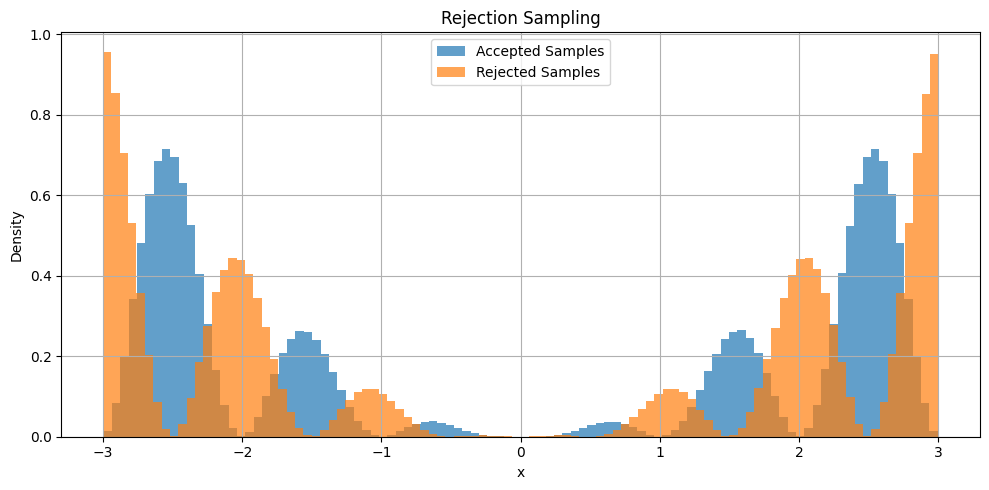

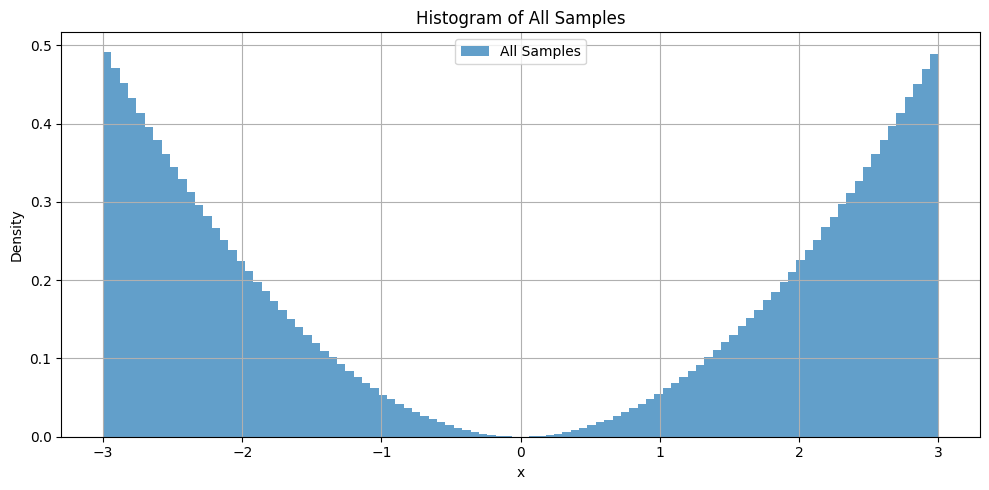

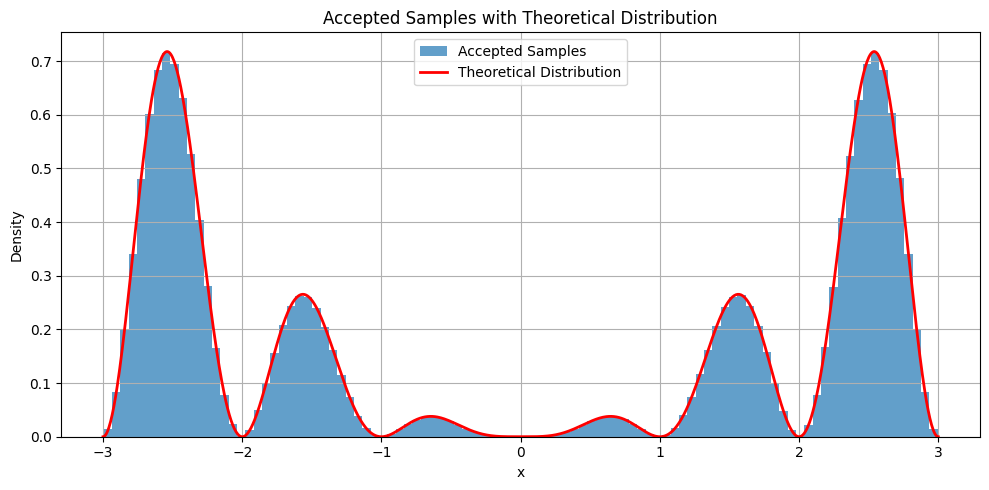

In [13]:
x_vals = np.linspace(-3, 3, 1000)
y_vals = f_vectorized(x_vals, A)

X, rej_vec, acc_count = rejection_sampling(NUM_SAMPLES)

print("Acceptance count:", acc_count)
print("Acceptance rate:", acc_count / NUM_SAMPLES)

plt.figure(figsize=(10, 5))
plt.hist(X[rej_vec == 1], bins=100, density=True, alpha=0.7, label="Accepted Samples")
plt.hist(X[rej_vec == 0], bins=100, density=True, alpha=0.7, label="Rejected Samples")
plt.title("Rejection Sampling")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Plotting the histogram of all samples
plt.figure(figsize=(10, 5))
plt.hist(X, bins=100, density=True, alpha=0.7, label="All Samples")
plt.title("Histogram of All Samples")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Plotting the histogram of accepted samples with the theoretical distribution
plt.figure(figsize=(10, 5))
plt.hist(X[rej_vec == 1], bins=100, density=True, alpha=0.7, label="Accepted Samples")
plt.plot(x_vals, y_vals, label="Theoretical Distribution", color="red", linewidth=2)
plt.title("Accepted Samples with Theoretical Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Acceptance count: 1641218
Acceptance rate: 0.1641218


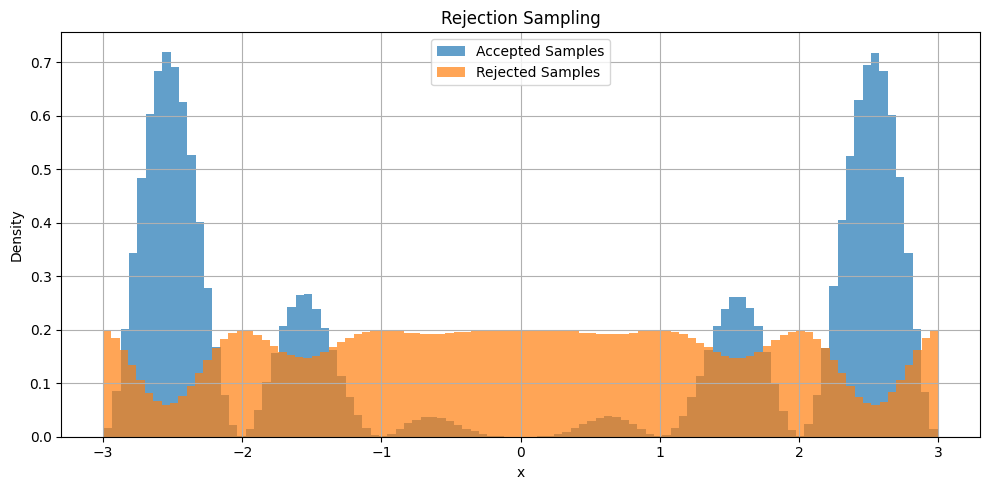

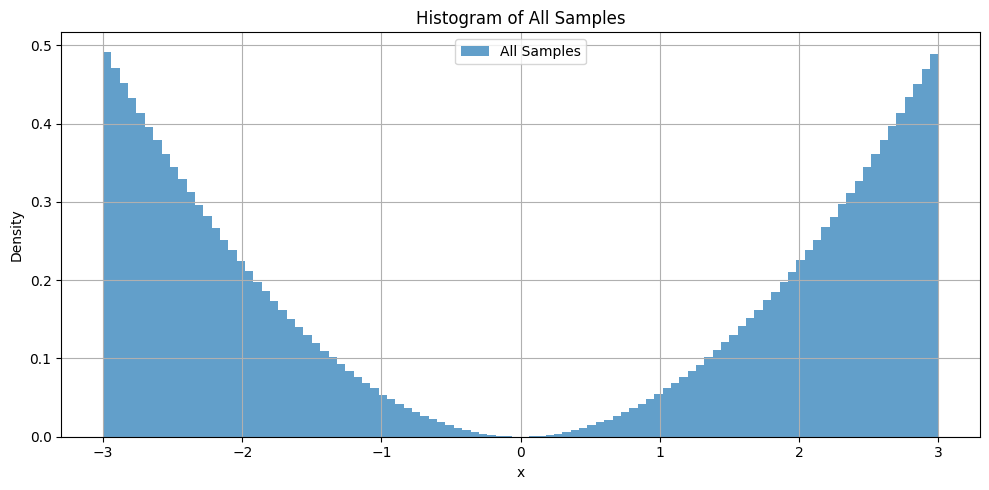

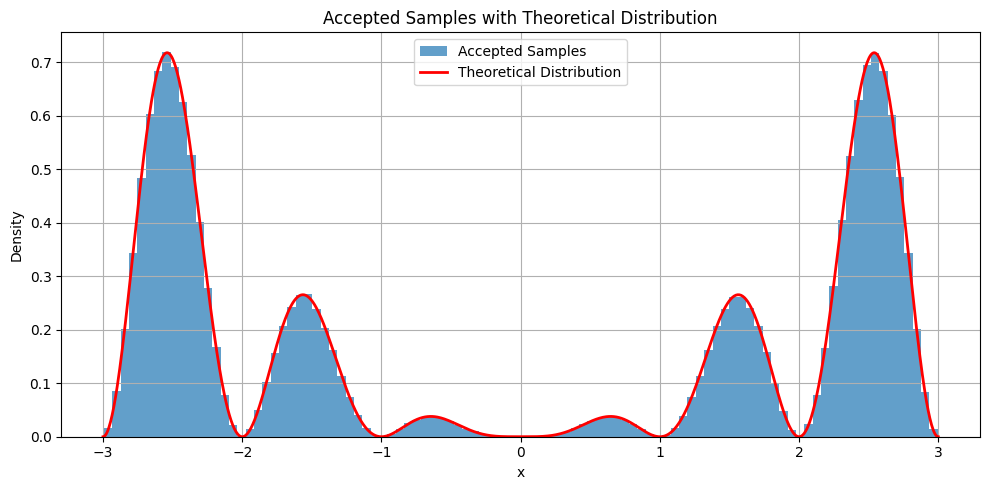

In [14]:
X2, rej_vec2, acc_count2 = rejection_sampling_2(NUM_SAMPLES)

print("Acceptance count:", acc_count2)
print("Acceptance rate:", acc_count2 / NUM_SAMPLES)

plt.figure(figsize=(10, 5))
plt.hist(X2[rej_vec2 == 1], bins=100, density=True, alpha=0.7, label="Accepted Samples")
plt.hist(X2[rej_vec2 == 0], bins=100, density=True, alpha=0.7, label="Rejected Samples")
plt.title("Rejection Sampling")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Plotting the histogram of all samples
plt.figure(figsize=(10, 5))
plt.hist(X, bins=100, density=True, alpha=0.7, label="All Samples")
plt.title("Histogram of All Samples")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Plotting the histogram of accepted samples with the theoretical distribution
plt.figure(figsize=(10, 5))
plt.hist(X2[rej_vec2 == 1], bins=100, density=True, alpha=0.7, label="Accepted Samples")
plt.plot(x_vals, y_vals, label="Theoretical Distribution", color="red", linewidth=2)
plt.title("Accepted Samples with Theoretical Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Median: 1.328582615292987
Confidence Interval: (-1.4046931762953794, 1.6391828464714902)
Confidence Interval width: 3.0438760227668693
0.9 Quantile: 2.6428424300385056
Confidence Interval: (2.557042148301514, 2.831491234302071)
Confidence Interval width: 0.2744490860005566
Mean: 0.135842904077108
Confidence Interval: (-0.1803156492763379, 0.45200145743055387)
Confidence Interval width: 0.6323171067068918


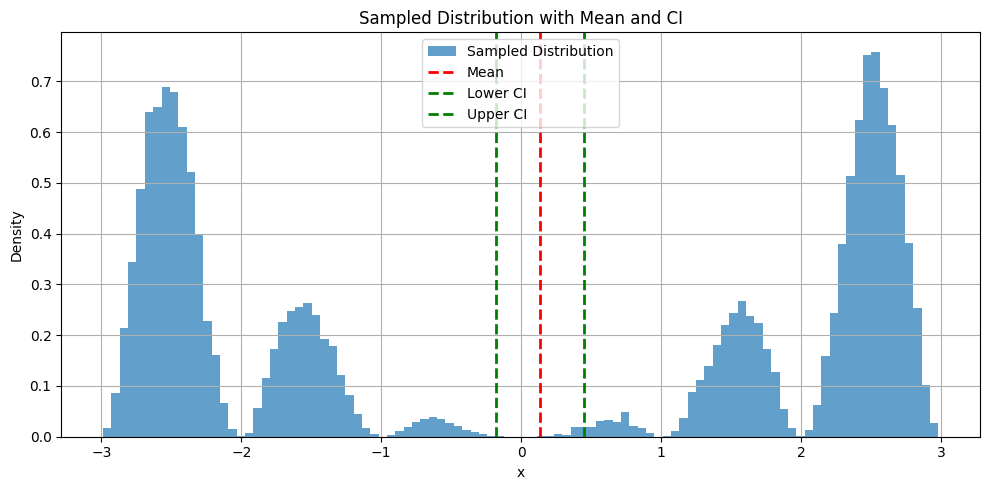

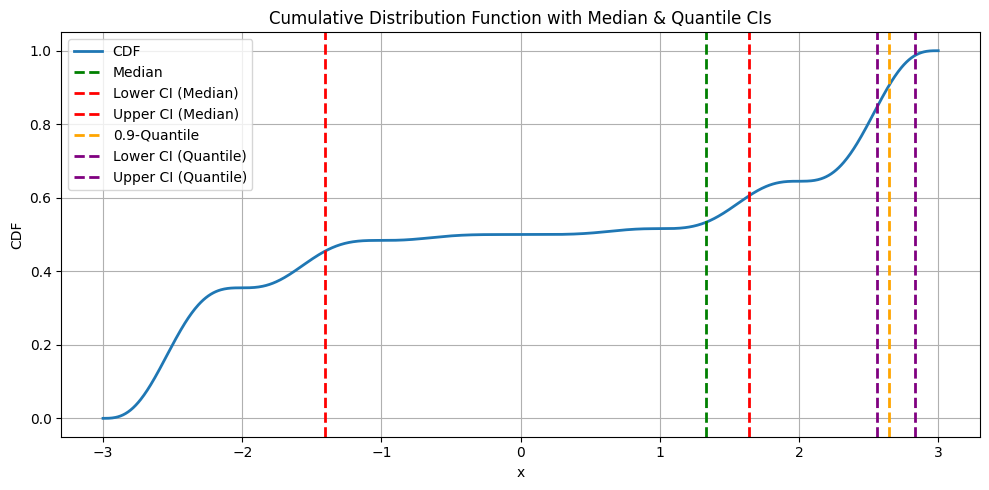

In [15]:
repetitions = 20000
sample = sample_valid(n_valid=repetitions, batch_size=1000)

num_subsamples = 200
subsample = sample[:num_subsamples]  # Take the first 200 samples

ordered_subsample = np.sort(subsample)

# Median
median = np.median(ordered_subsample)
l_idx_CI = math.floor((0.5 * num_subsamples) - (0.98 * math.sqrt(num_subsamples)))
u_idx_CI = math.ceil((0.5 * num_subsamples) + 1 + (0.98 * math.sqrt(num_subsamples)))

l_CI = ordered_subsample[l_idx_CI]
u_CI = ordered_subsample[u_idx_CI]


# 0.9 quantile

q = 0.9
quantile = np.quantile(ordered_subsample, q)
l_idx_q = math.floor((q * num_subsamples) - (0.98 * math.sqrt(num_subsamples)))
u_idx_q = math.ceil((q * num_subsamples) + 1 + (0.98 * math.sqrt(num_subsamples)))

l_CI_q = ordered_subsample[l_idx_q]
u_CI_q = ordered_subsample[u_idx_q]


# Mean
sample_std_dev = np.std(
    subsample, ddof=1
)  # Sample standard deviation with Bessel's correction
sample_mean = np.mean(subsample)
l_CI_mean = sample_mean - 1.96 * sample_std_dev / math.sqrt(num_subsamples)
u_CI_mean = sample_mean + 1.96 * sample_std_dev / math.sqrt(num_subsamples)


print("Median:", median)
print("Confidence Interval:", (float(l_CI), float(u_CI)))
print("Confidence Interval width:", float(u_CI) - float(l_CI))
print("=================================================================")
print("0.9 Quantile:", quantile)
print("Confidence Interval:", (float(l_CI_q), float(u_CI_q)))
print("Confidence Interval width:", float(u_CI_q) - float(l_CI_q))
print("=================================================================")
print("Mean:", sample_mean)
print("Confidence Interval:", (float(l_CI_mean), float(u_CI_mean)))
print("Confidence Interval width:", float(u_CI_mean) - float(l_CI_mean))


plt.figure(figsize=(10, 5))
plt.hist(sample, bins=100, density=True, alpha=0.7, label="Sampled Distribution")
plt.axvline(sample_mean, color="red", linestyle="dashed", linewidth=2, label="Mean")
plt.axvline(l_CI_mean, color="green", linestyle="dashed", linewidth=2, label="Lower CI")
plt.axvline(u_CI_mean, color="green", linestyle="dashed", linewidth=2, label="Upper CI")
plt.title("Sampled Distribution with Mean and CI")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Create x-values matching the density array and compute the CDF.
x_points = np.linspace(-3, 3, len(y_vals))
dx = x_points[1] - x_points[0]
cdf = np.cumsum(y_vals) * dx

plt.figure(figsize=(10, 5))
plt.plot(x_points, cdf, linewidth=2, label="CDF")

# Add median and its confidence intervals.
plt.axvline(median, color="green", linestyle="dashed", linewidth=2, label="Median")
plt.axvline(
    l_CI, color="red", linestyle="dashed", linewidth=2, label="Lower CI (Median)"
)
plt.axvline(
    u_CI, color="red", linestyle="dashed", linewidth=2, label="Upper CI (Median)"
)

# Add quantile and its confidence intervals.
plt.axvline(
    quantile, color="orange", linestyle="dashed", linewidth=2, label=f"{q}-Quantile"
)
plt.axvline(
    l_CI_q, color="purple", linestyle="dashed", linewidth=2, label="Lower CI (Quantile)"
)
plt.axvline(
    u_CI_q, color="purple", linestyle="dashed", linewidth=2, label="Upper CI (Quantile)"
)

plt.title("Cumulative Distribution Function with Median & Quantile CIs")
plt.xlabel("x")
plt.ylabel("CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Median: 1.328582615292987
Confidence Interval: (-1.4834962913787413, 1.5411004656463358)
Confidence Interval width: 3.024596757025077
0.9 Quantile: 2.6428424300385056
Confidence Interval: (2.574639305103972, 2.7016319176103902)
Confidence Interval width: 0.12699261250641802
Mean: 0.135842904077108
Confidence Interval: (-0.29442210582352274, 0.36247056346184975)
Confidence Interval width: 0.6568926692853725


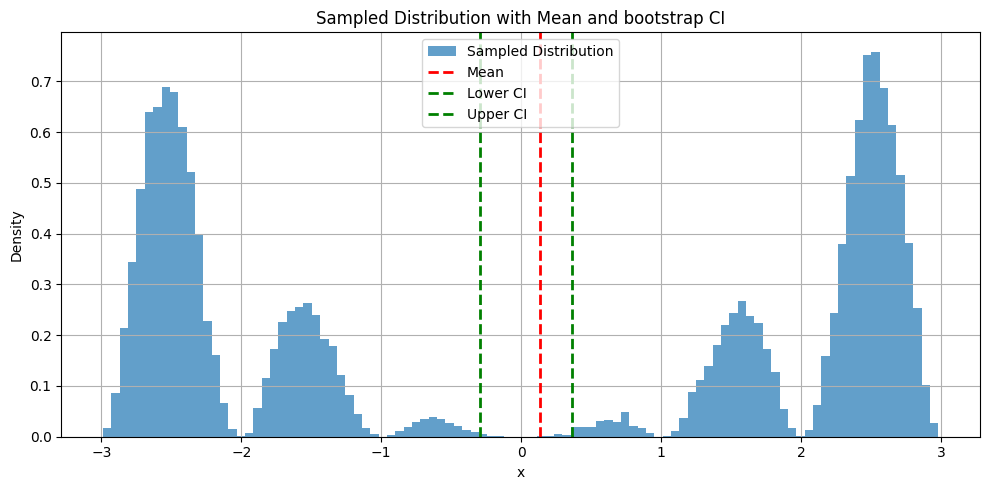

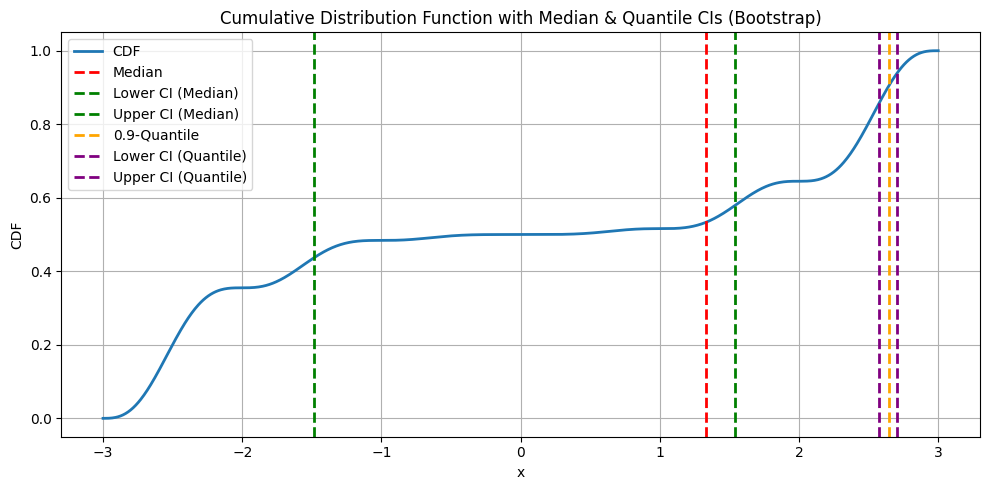

In [16]:
# Computing confidence intervals with bootstrap procedure

for i in range(1000):
    # Generate bootstrap samples
    boot_sample = np.random.choice(sample, size=num_subsamples, replace=True)
    b_median = np.median(boot_sample)
    b_quantile = np.quantile(boot_sample, q)
    b_mean = np.mean(boot_sample)

    if i == 0:
        medians = np.array([b_median])
        quantiles = np.array([b_quantile])
        means = np.array([b_mean])

    else:
        medians = np.append(medians, b_median)
        quantiles = np.append(quantiles, b_quantile)
        means = np.append(means, b_mean)

# Sort
medians = list(np.sort(medians))
quantiles = list(np.sort(quantiles))
means = list(np.sort(means))

# Compute the confidence intervals

med_l_CI_boot = medians[25]
med_u_CI_boot = medians[975]

q_l_CI_boot = quantiles[25]
q_u_CI_boot = quantiles[975]

mean_l_CI_boot = means[25]
mean_u_CI_boot = means[975]

print("Median:", median)
print("Confidence Interval:", (float(med_l_CI_boot), float(med_u_CI_boot)))
print("Confidence Interval width:", float(med_u_CI_boot) - float(med_l_CI_boot))
print("=================================================================")
print("0.9 Quantile:", quantile)
print("Confidence Interval:", (float(q_l_CI_boot), float(q_u_CI_boot)))
print("Confidence Interval width:", float(q_u_CI_boot) - float(q_l_CI_boot))
print("=================================================================")
print("Mean:", sample_mean)
print("Confidence Interval:", (float(mean_l_CI_boot), float(mean_u_CI_boot)))
print("Confidence Interval width:", float(mean_u_CI_boot) - float(mean_l_CI_boot))


plt.figure(figsize=(10, 5))
plt.hist(sample, bins=100, density=True, alpha=0.7, label="Sampled Distribution")
plt.axvline(sample_mean, color="red", linestyle="dashed", linewidth=2, label="Mean")
plt.axvline(
    mean_l_CI_boot, color="green", linestyle="dashed", linewidth=2, label="Lower CI"
)
plt.axvline(
    mean_u_CI_boot, color="green", linestyle="dashed", linewidth=2, label="Upper CI"
)
plt.title("Sampled Distribution with Mean and bootstrap CI")
plt.xlabel("x")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(x_points, cdf, linewidth=2, label="CDF")

# Add median and its confidence intervals.
plt.axvline(median, color="red", linestyle="dashed", linewidth=2, label="Median")
plt.axvline(
    med_l_CI_boot,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label="Lower CI (Median)",
)
plt.axvline(
    med_u_CI_boot,
    color="green",
    linestyle="dashed",
    linewidth=2,
    label="Upper CI (Median)",
)

# Add quantile and its confidence intervals.
plt.axvline(
    quantile, color="orange", linestyle="dashed", linewidth=2, label=f"{q}-Quantile"
)
plt.axvline(
    q_l_CI_boot,
    color="purple",
    linestyle="dashed",
    linewidth=2,
    label="Lower CI (Quantile)",
)
plt.axvline(
    q_u_CI_boot,
    color="purple",
    linestyle="dashed",
    linewidth=2,
    label="Upper CI (Quantile)",
)

plt.title("Cumulative Distribution Function with Median & Quantile CIs (Bootstrap)")
plt.xlabel("x")
plt.ylabel("CDF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Number of confidence intervals (computed with normal approximation) that contain the true mean 0: 94
Number of confidence intervals (computed with bootstrap) that contain the true mean 0: 95


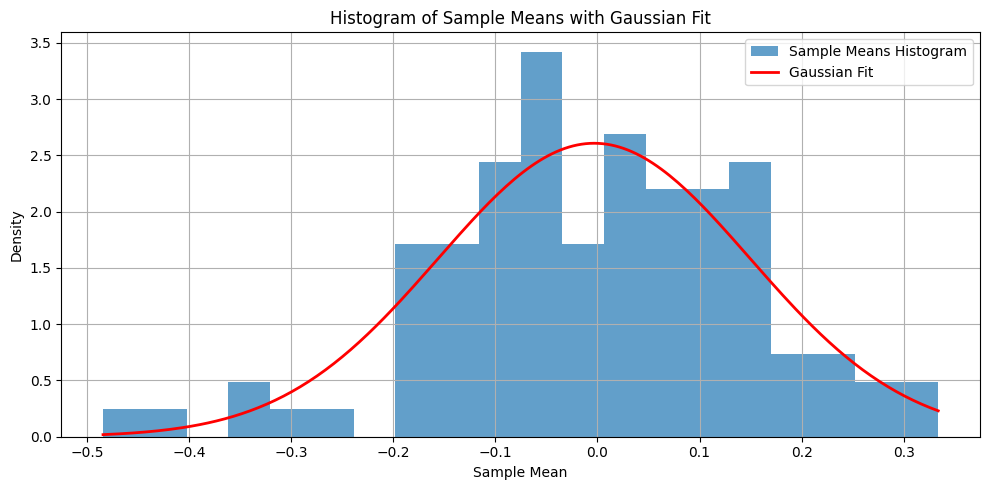

In [17]:
repetitions = 20000
sample = sample_valid(n_valid=repetitions, batch_size=1000)
n_sub = 200
num_bootstrap = 1000  # number of bootstrap repetitions
CI_contains_bootstrap = 0
CI_contains = 0

sm_array = np.empty(100)

for i in range(100):
    subset = sample[i * n_sub : (i + 1) * n_sub]
    bootstrap_means = np.empty(num_bootstrap)

    for j in range(num_bootstrap):
        boot_sample = np.random.choice(subset, size=n_sub, replace=True)
        bootstrap_means[j] = np.mean(boot_sample)

    boot_l_CI_mean = np.percentile(bootstrap_means, 2.5)
    boot_u_CI_mean = np.percentile(bootstrap_means, 97.5)

    sample_std_dev = np.std(
        subset, ddof=1
    )  # Sample standard deviation with Bessel's correction
    sample_mean = np.mean(subset)
    sm_array[i] = sample_mean
    l_CI_mean = sample_mean - 1.96 * sample_std_dev / math.sqrt(len(subset))
    u_CI_mean = sample_mean + 1.96 * sample_std_dev / math.sqrt(len(subset))

    if l_CI_mean <= 0 <= u_CI_mean:
        CI_contains += 1
    if boot_l_CI_mean <= 0 <= boot_u_CI_mean:
        CI_contains_bootstrap += 1


print(
    "Number of confidence intervals (computed with normal approximation) that contain the true mean 0:",
    CI_contains,
)
print(
    "Number of confidence intervals (computed with bootstrap) that contain the true mean 0:",
    CI_contains_bootstrap,
)

# Plotting the histogram of sample means
mean_sm = np.mean(sm_array)
std_sm = np.std(sm_array, ddof=1)
x_fit = np.linspace(sm_array.min(), sm_array.max(), 200)
pdf_fit = (
    1 / (std_sm * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x_fit - mean_sm) / std_sm) ** 2)
)

plt.figure(figsize=(10, 5))
plt.hist(sm_array, bins=20, density=True, alpha=0.7, label="Sample Means Histogram")
plt.plot(x_fit, pdf_fit, color="red", linewidth=2, label="Gaussian Fit")
plt.title("Histogram of Sample Means with Gaussian Fit")
plt.xlabel("Sample Mean")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()